In [1]:
import numpy as np
from math import exp, sqrt
import matplotlib.pyplot as plt
from BayesODE import var_car, cov_car

In [2]:
def rootgen(r0, n):
    roots = np.zeros(n)
    r = r0
    for k in range(n):
        roots[k] = -r
        r = exp(r0*(k+1))
    return roots

In [3]:
r0 = 1
roots = rootgen(r0, 3) #All roots need to be negative
tseq = np.linspace(0.1,0.5,10)
V = var_car(tseq, roots)

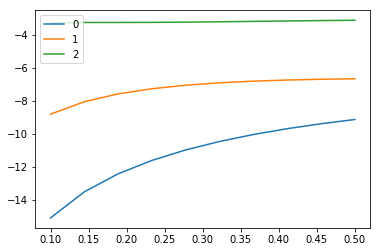

In [4]:
for k in range(len(roots)):
    plt.plot(tseq, np.log(V[:,k,k]), label=k)
plt.legend(loc='upper left')
plt.show()

In [5]:
cov = cov_car(tseq, roots)

In [6]:
def getgamma(cov):
    gamma = np.zeros(cov.shape)
    for t in range(cov.shape[0]):
        C = np.diag(np.diag(cov[t]))
        C_half = np.linalg.cholesky(C)
        gamma[t] = np.linalg.multi_dot([np.linalg.pinv(C_half), cov[t], C_half])
    return gamma

In [7]:
gamma = getgamma(cov)
for k in range(len(roots)):
    plt.plot(tseq, np.log(gamma[:,k,k]), label=k)
plt.legend(loc='upper left')
plt.show()
#plt.plot(tseq,gamma)

LinAlgError: Matrix is not positive definite

In [ ]:
def decorrelation(roots, k, tol=1e-5):
    t = 0.1
    
    while True:
        cov = cov_car(np.array([t]), roots)
        gamma_k = getgamma(cov)[0][k,k]
        if abs(gamma_k-1/exp(1)) < tol:
            return t
        elif gamma_k>1/exp(1):
            t = t - t/100
        else:
            t = t + t/100

In [ ]:
decorrelation(roots, 2)

# Unit Test

In [ ]:
r0 = 1
roots = rootgen(r0, 3)

delta = -roots
D = np.diag(delta)
p = len(roots)
Q = np.zeros((p, p))

row = np.ones(p)
for i in range(p):
    Q[i] = row
    row = row*roots

Q_inv = np.linalg.pinv(Q)
Gamma = np.linalg.multi_dot([Q, D, Q_inv])

In [ ]:
from sympy import symbols, expand, Poly
s = symbols('s')
product = 1
for root in roots:
    product = product * (s - root)
coeffs = Poly(expand(product)).coeffs()
np.allclose(np.array(coeffs[:0:-1], dtype='float'),Gamma[-1])

In [ ]:
def V_euler_N1(Sigma, Delta_t):
    return Sigma*Delta_t

In [ ]:
def var_car_test(Q, D, Sigma, Delta_t):
    p = len(D)
    delta = np.diag(D)
    Q_inv = np.linalg.pinv(Q)
    Gamma = np.linalg.multi_dot([Q, D, Q_inv]) #Q*D*Q^-1
    Sigma_tilde = np.linalg.multi_dot([Q_inv, Sigma, Q_inv.T]) #Q^-1*Sigma*Q^-1'

    V_tilde = np.zeros((p,p))
    for i in range(p):
        for j in range(i, p):
            V_tilde[i,j] = Sigma_tilde[i,j] / (delta[i] + delta[j]) * (1- exp(- (delta[i] + delta[j]) * Delta_t)) #V_tilde
            V_tilde[j,i] = V_tilde[i,j]

    V = np.linalg.multi_dot([Q, V_tilde, Q.T]) #V_deltat
    return V

In [ ]:
Delta_T = 10**-np.linspace(5, 10, 10)
Q = np.ones((3,3))
D = np.diag([1,2,3])
Sigma = np.random.rand(3,3)
Sigma = Sigma.dot(Sigma.T)

compare = np.zeros(len(Delta_T))
for t in range(len(Delta_T)):
    euler = V_euler_N1(Sigma, Delta_T[t])
    true = var_car_test(Q, D, Sigma, Delta_T[t])
    compare[t] = np.max((abs(euler - true)/(abs(euler) + 0.1)))
    
plt.plot(np.log10(Delta_T), compare)

In [ ]:
def V_euler(B, N, Sigma, Gamma, delta_t):
    p = len(Gamma)
    X = np.zeros((N,p,B))
    Z = np.random.normal(0,1,(N,p,B))
    for n in range(N):
        deltaB_n = sqrt(delta_t)*Z[n]
        if n==0:
            X[n] = np.linalg.cholesky(Sigma).dot(deltaB_n)
        else:
            X[n] = X[n-1] + Gamma.dot(X[n-1])*delta_t + np.linalg.cholesky(Sigma).dot(deltaB_n)
    return np.cov(X[N-1])

In [ ]:
Q = np.ones((3,3))
Q_inv = np.linalg.pinv(Q)
D = np.diag([1,2,3])
Sigma = np.random.rand(3,3)
Sigma = Sigma.dot(Sigma.T)
Gamma = np.linalg.multi_dot([Q, D, Q_inv]) #Q*D*Q^-1

B = 10000
N = 10
T = 10**-np.linspace(5, 10, 10)

compare = np.zeros(len(T))
for t in range(len(T)):
    euler = V_euler(B, N, Sigma, Gamma, T[t]/N)
    true = var_car_test(Q, D, Sigma, T[t])
    compare[t] = np.max((abs(euler - true)/(abs(euler) + 0.1)))
    
plt.plot(np.log10(Delta_T), compare)